In [1]:
# Set up
%pylab inline

# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.stats.multitest
from sklearn.cluster import KMeans

############ Set up paths #############
SAVEPLOT = True
MIN_CAUSAL_SCORE = 0.3 
GENEANNOT = "/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv"

allstrs = pd.read_csv(os.path.join(DATADIR, "misc", "all_analyzed_strs.tab"), sep="\t")

# Load eSTRs
estrs = pd.read_csv(os.path.join(RESULTSDIR, "SuppTable_CAVIAR.tsv"), sep="\t")
geneannot = pd.read_csv(GENEANNOT)
geneannot["gene"] = geneannot["gene.id"].apply(lambda x: x.split(".")[0])
estrs = pd.merge(estrs, geneannot[["gene", "gene.strand","gene.start","gene.stop"]], on=["gene"])
estrs["motif"] = estrs.apply(lambda x: x["str.motif.forward"] if x["gene.strand"]=="+" else x["str.motif.reverse"], 1)
estrs["dist.tss"] = estrs.apply(lambda x: (x["str.start"]-x["gene.start"]) if x["gene.strand"]=="+" else (x["gene.stop"]-x["str.start"]), 1)

# All ref data
ref = pd.read_csv(os.path.join(DATADIR, "misc", "annotations", "hg19.hipstr_reference_annot.bed"), sep="\t")
ref["str.start"]=ref["start"]
ref = pd.merge(ref, allstrs[["chrom","str.start"]].drop_duplicates(), on=["chrom","str.start"])

causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]
rcausal = pd.merge(causal, ref[["chrom","str.start","coding", "5utr","3utr","introns", "hg19_promoter_3kb"]], on=["chrom","str.start"])


Populating the interactive namespace from numpy and matplotlib


In [29]:
all_annot = ["all","intergenic","introns","promoter-up", "promoter-down", "5utr", "3utr",  "coding"]

labels = []
num_total = []
num_pos = []
perc = []
xval = []

x = 0
for period in range(0, 7):
    for annotation in all_annot:
        d = rcausal
        if period != 0:
            d = rcausal[rcausal["str.motif.forward"].apply(len)==period]
        if annotation != "all": 
            if annotation == "intergenic":
                d = d[(d["introns"]+d["hg19_promoter_3kb"]+d["5utr"]+d["3utr"]+d["coding"])==0]
            elif annotation == "promoter-up":
                d = d[(d["dist.tss"]>-3000) & (d["dist.tss"]<0)]
            elif annotation == "promoter-down":
                d = d[(d["dist.tss"]>0) & (d["dist.tss"]<3000)]
            else:
                d = d[d[annotation]>0]
        labels.append(("%s:%s"%(annotation, period)).replace("_",""))
        num_total.append(d.shape[0])
        num_pos.append(d[d["beta"]>0].shape[0])
        if num_total[-1] > 0:
            perc.append(num_pos[-1]*1.0/num_total[-1])
        else: perc.append(np.nan)
        xval.append(x)
        x += 1
    x += 5

In [33]:
dirdata = pd.DataFrame({"label": labels, "total": num_total, "pos": num_pos,"perc": perc, "xval": xval})
dirdata.loc[dirdata["total"]<3,"perc"] = np.nan

def GetStderr(perc, total):
    if total == 0: return np.nan
    else: return np.sqrt(perc*(1-perc)/total)
dirdata["stderr"] = dirdata.apply(lambda x: GetStderr(x["perc"],x["total"]), 1)
# pvals.append(scipy.stats.binom_test(perc*df_bin.shape[0], df_bin.shape[0]))
dirdata["pval"] = dirdata.apply(lambda x: scipy.stats.binom_test(x["pos"], x["total"]), 1)
#dirdata.sort_values("pval")

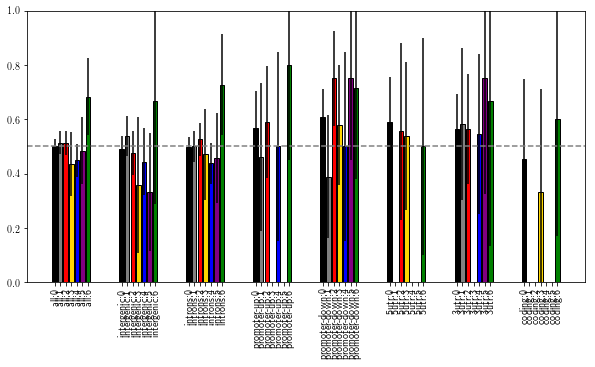

In [26]:
#fig = plt.figure()
#fig.set_size_inches((10, 5))
#ax = fig.add_subplot(111)
#ax.bar(dirdata["xval"], dirdata["perc"], yerr=1.96*dirdata["stderr"],
#       color=["black","gray","red","gold","blue","purple","green"], edgecolor="black")
#ax.axhline(y=0.5, linestyle="dashed", color="gray")
#ax.set_xticks(dirdata["xval"])
#ax.set_xticklabels(dirdata["label"], rotation=90)
#ax.set_ylim(bottom=0, top=1);

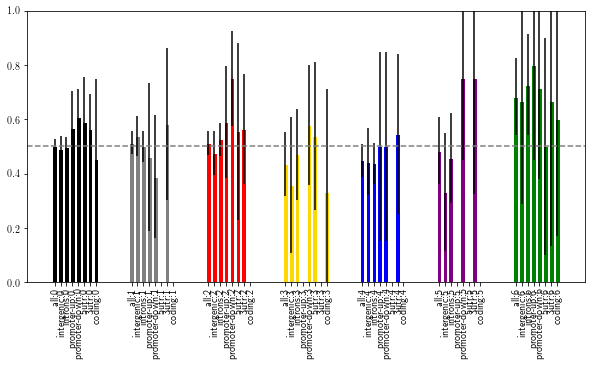

In [34]:
colors = ["black","gray","red","gold","blue","purple","green"]
dirdata["period"] = dirdata["label"].apply(lambda x: int(x.split(":")[1]))
#dirdata = dirdata.sort_values("period", ascending=True)
dirdata["color"] = dirdata["period"].apply(lambda x: colors[x])
fig = plt.figure()
fig.set_size_inches((10, 5))
ax = fig.add_subplot(111)
ax.bar(dirdata["xval"], dirdata["perc"], yerr=1.96*dirdata["stderr"],
       color=dirdata["color"], edgecolor="white")
ax.axhline(y=0.5, linestyle="dashed", color="gray")
ax.set_xticks(dirdata["xval"])
ax.set_xticklabels(dirdata["label"], rotation=90)
ax.set_ylim(bottom=0, top=1);

In [42]:
# By strand
mpairs = [("A","T"),("AC","GT"),("AAC","GTT"), ("AAAC","GTTT")]
labels = []
num_total = []
num_pos = []
perc = []
xval = []

x = 0
for annotation in ["all","intergenic","promoter-up","promoter-down","introns"]:
    for mpair in mpairs:
        for motif in mpair:
            d = rcausal[rcausal["motif"]==motif]
            if annotation != "all": 
                if annotation == "intergenic":
                    d = d[(d["introns"]+d["hg19_promoter_3kb"]+d["5utr"]+d["3utr"]+d["coding"])==0]
                elif annotation == "promoter-up":
                    d = d[(d["dist.tss"]>-3000) & (d["dist.tss"]<0)]
                elif annotation == "promoter-down":
                    d = d[(d["dist.tss"]>0) & (d["dist.tss"]<3000)]
                else:
                    d = d[d[annotation]>0]
            labels.append(("%s:%s"%(annotation, motif)).replace("_",""))
            num_total.append(d.shape[0])
            #count.append(r.shape[0])
            num_pos.append(d[d["beta"]>0].shape[0])
            if num_total[-1] > 0:
                perc.append(num_pos[-1]*1.0/num_total[-1])
            else: perc.append(np.nan)
            xval.append(x)
            x += 1
    x += 2
    
sdata = pd.DataFrame({"label": labels, "total": num_total, "pos": num_pos,"perc": perc, "xval": xval})
sdata.loc[sdata["total"]<3,"perc"] = np.nan
sdata["stderr"] = sdata.apply(lambda x: GetStderr(x["perc"],x["total"]), 1)
sdata["pval"] = sdata.apply(lambda x: scipy.stats.binom_test(x["pos"], x["total"]), 1)
sdata #.sort_values("perc")

,label,perc,pos,total,xval,stderr,pval
0,all:A,0.497908,119,239,0,0.032342,1.000000
1,all:T,0.525692,133,253,1,0.031393,0.450654
2,all:AC,0.486486,90,185,2,0.036747,0.768786
3,all:GT,0.532710,114,214,3,0.034106,0.374225
4,all:AAC,0.500000,4,8,4,0.176777,1.000000
5,all:GTT,0.538462,7,13,5,0.138264,1.000000
6,all:AAAC,0.428571,9,21,6,0.107990,0.663624
7,all:GTTT,0.463415,19,41,7,0.077878,0.755229
8,intergenic:A,0.547368,52,95,10,0.051068,0.411910
9,intergenic:T,0.546667,41,75,11,0.057483,0.488683


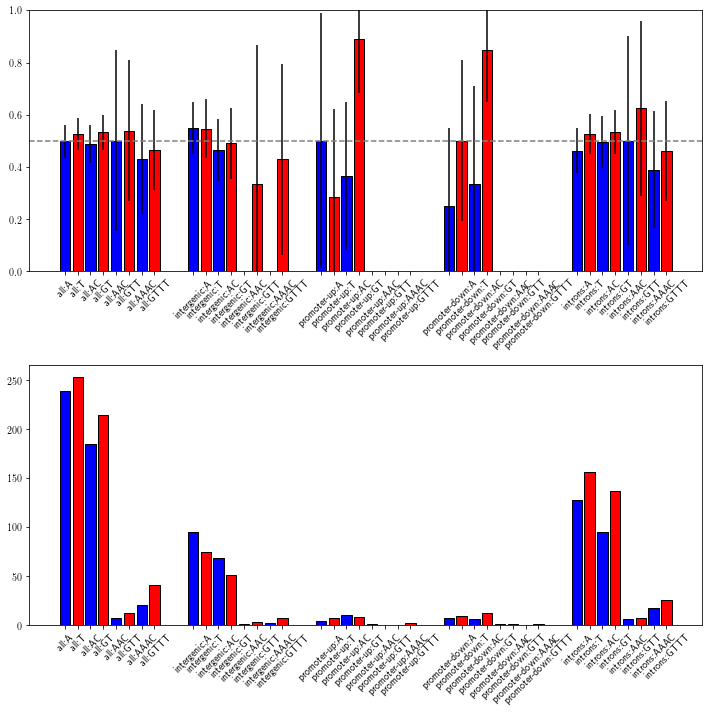

In [43]:
fig = plt.figure()
fig.set_size_inches((10, 10))
ax = fig.add_subplot(211)
ax.bar(sdata["xval"], sdata["perc"], yerr=1.96*sdata["stderr"],
       color=["blue","red"], edgecolor="black")
ax.axhline(y=0.5, linestyle="dashed", color="gray")
ax.set_xticks(sdata["xval"])
ax.set_xticklabels(sdata["label"], rotation=45)
ax.set_ylim(bottom=0, top=1);

ax = fig.add_subplot(212)
ax.bar(sdata["xval"], (sdata["total"]), 
       color=["blue","red"], edgecolor="black")
ax.set_xticks(sdata["xval"])
ax.set_xticklabels(sdata["label"], rotation=45);
fig.tight_layout()